<a href="https://colab.research.google.com/github/JohnMorrisonn/DS-Unit-2-Regression-Classification/blob/master/module3/213_assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


- [X] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [X] Do exploratory visualizations with Seaborn.
- [X] Do one-hot encoding of categorical features.
- [X ] Do feature selection with `SelectKBest`.
- [ X] Fit a linear regression model with multiple features.
- [X ] Get mean absolute error for the test set.
- [X ] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).
(That book is good regardless of whether your cultural worldview is inferential statistics or predictive machine learning)
- [ ] Read Leo Breiman's paper, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

In [0]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.0.0)
Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.6/dist-packages (2.3.0)
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.1.0)
Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
print(df.shape)
print(df.dtypes)
df.head()

(23040, 21)
BOROUGH                             int64
NEIGHBORHOOD                       object
BUILDING_CLASS_CATEGORY            object
TAX_CLASS_AT_PRESENT               object
BLOCK                               int64
LOT                                 int64
EASE-MENT                         float64
BUILDING_CLASS_AT_PRESENT          object
ADDRESS                            object
APARTMENT_NUMBER                   object
ZIP_CODE                          float64
RESIDENTIAL_UNITS                 float64
COMMERCIAL_UNITS                  float64
TOTAL_UNITS                       float64
LAND_SQUARE_FEET                   object
GROSS_SQUARE_FEET                 float64
YEAR_BUILT                        float64
TAX_CLASS_AT_TIME_OF_SALE           int64
BUILDING_CLASS_AT_TIME_OF_SALE     object
SALE_PRICE                          int64
SALE_DATE                          object
dtype: object


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,CHELSEA,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,FASHION,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,FASHION,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,GREENWICH VILLAGE-WEST,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019


In [0]:
# Filter the data for the proper price, building class, dates, and train/test

# Remove columns with too many nulls
df = df.drop(columns=['EASE-MENT', 'APARTMENT_NUMBER'])

# Filter for just One Family Dwellings
# Filter for price range 100k - 2million
df = df.query("BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS'")
df = df[(df['SALE_PRICE'] >= 100000) & (df['SALE_PRICE'] <= 2000000)]

# Split into January-March and April sections
# Make sale date created section into datetime
cut_off = '2019-04-01'
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)

# Make train and test datasets with Jan-March and April, respectively
df = df.set_index('SALE_DATE')
df['LAND_SQUARE_FEET'] = df['LAND_SQUARE_FEET'].str.replace(',','').astype(int)
train = df[:'2019-03'].reset_index()
test = df['2019-04':].reset_index()

# Check that it adds up to original df
train.shape, test.shape
assert (train.shape[0] + test.shape[0] == len(df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS'))

In [0]:
df.dtypes

BOROUGH                             int64
NEIGHBORHOOD                       object
BUILDING_CLASS_CATEGORY            object
TAX_CLASS_AT_PRESENT               object
BLOCK                               int64
LOT                                 int64
BUILDING_CLASS_AT_PRESENT          object
ADDRESS                            object
ZIP_CODE                          float64
RESIDENTIAL_UNITS                 float64
COMMERCIAL_UNITS                  float64
TOTAL_UNITS                       float64
LAND_SQUARE_FEET                    int64
GROSS_SQUARE_FEET                 float64
YEAR_BUILT                        float64
TAX_CLASS_AT_TIME_OF_SALE           int64
BUILDING_CLASS_AT_TIME_OF_SALE     object
SALE_PRICE                          int64
dtype: object

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


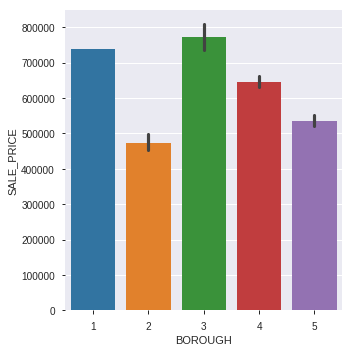

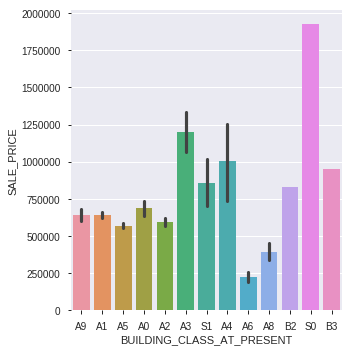

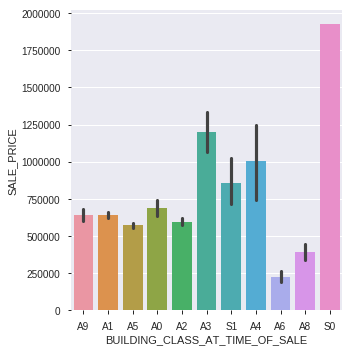

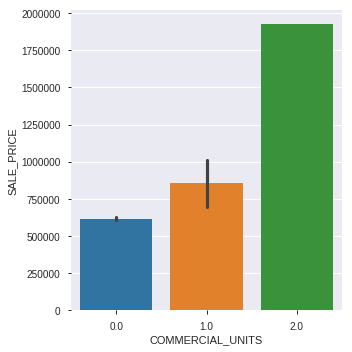

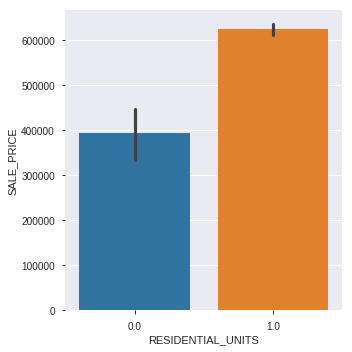

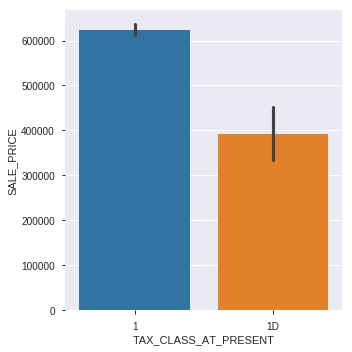

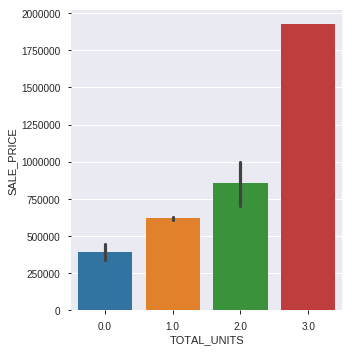

In [0]:
for col in sorted(train.columns):
    if train[col].nunique() < 15 and train[col].nunique() > 1:
        sns.catplot(x=col, y='SALE_PRICE', data=train, kind='bar')
        plt.show()

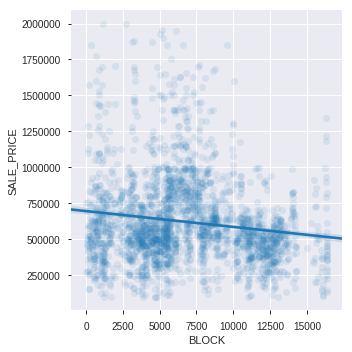

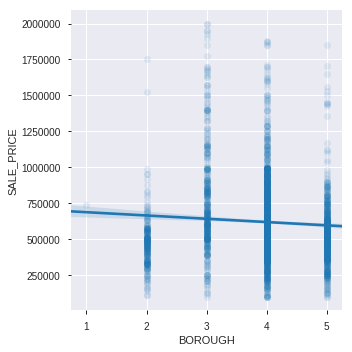

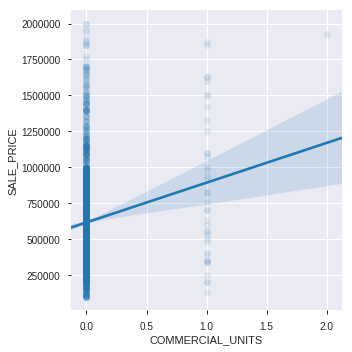

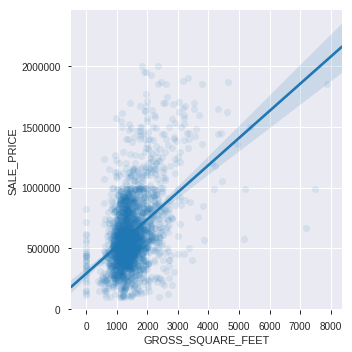

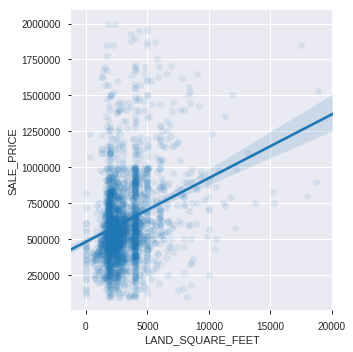

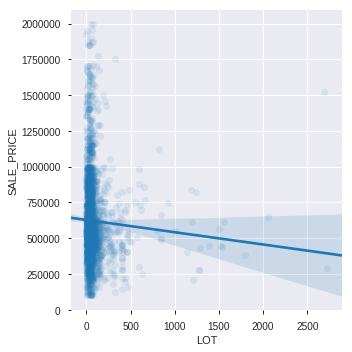

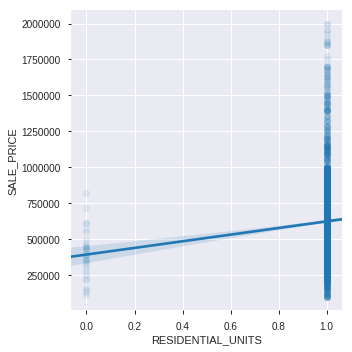

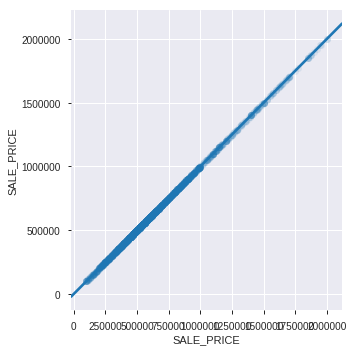

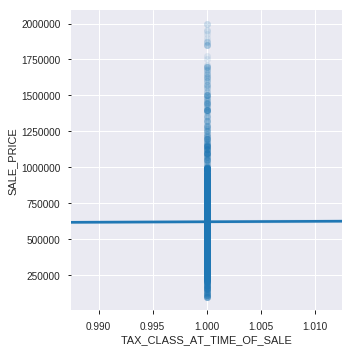

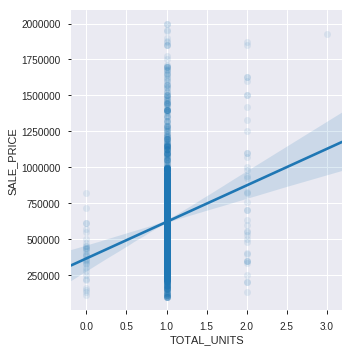

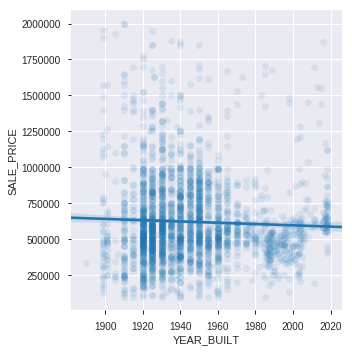

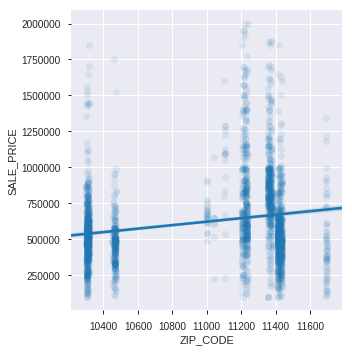

In [0]:
numeric = train.select_dtypes('number')
for col in sorted(numeric.columns):
    sns.lmplot(x=col, y='SALE_PRICE', data=train, scatter_kws=dict(alpha=0.1))
    plt.show()

In [0]:
# Look for categorical features
train.describe(exclude='number')

,SALE_DATE,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,BUILDING_CLASS_AT_TIME_OF_SALE
count,2517,2517,2517,2517,2517,2517,2517
unique,68,178,1,2,13,2507,11
top,2019-01-31 00:00:00,FLUSHING-NORTH,01 ONE FAMILY DWELLINGS,1,A1,130-52 LEFFERTS BOULEVARD,A1
freq,78,78,2517,2486,921,2,921
first,2019-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
last,2019-03-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
print(df['BUILDING_CLASS_AT_PRESENT'].value_counts())
df['BUILDING_CLASS_AT_TIME_OF_SALE'].value_counts()

A1    1188
A5     987
A2     494
A9     241
A0      85
S1      48
A3      43
A8      41
A4      17
A6      16
B2       2
B3       1
S0       1
Name: BUILDING_CLASS_AT_PRESENT, dtype: int64


A1    1189
A5     987
A2     496
A9     241
A0      85
S1      48
A3      43
A8      41
A4      17
A6      16
S0       1
Name: BUILDING_CLASS_AT_TIME_OF_SALE, dtype: int64

In [0]:
train['BOROUGH'] = train['BOROUGH'].astype(str)
test['BOROUGH'] = test['BOROUGH'].astype(str)

top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'


In [0]:
train.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq,first,last
BUILDING_CLASS_CATEGORY,2517,1,01 ONE FAMILY DWELLINGS,2517,NaN,NaN
TAX_CLASS_AT_PRESENT,2517,2,1,2486,NaN,NaN
BOROUGH,2517,5,4,1209,NaN,NaN
NEIGHBORHOOD,2517,11,OTHER,1914,NaN,NaN
BUILDING_CLASS_AT_TIME_OF_SALE,2517,11,A1,921,NaN,NaN
BUILDING_CLASS_AT_PRESENT,2517,13,A1,921,NaN,NaN
SALE_DATE,2517,68,2019-01-31 00:00:00,78,2019-01-01 00:00:00,2019-03-30 00:00:00
ADDRESS,2517,2507,130-52 LEFFERTS BOULEVARD,2,NaN,NaN


In [0]:
X_train_encoded

,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_QUEENS VILLAGE,NEIGHBORHOOD_BAYSIDE,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_LAURELTON,NEIGHBORHOOD_SO. JAMAICA-BAISLEY PARK,NEIGHBORHOOD_SPRINGFIELD GARDENS,NEIGHBORHOOD_GREAT KILLS,NEIGHBORHOOD_SOUTH OZONE PARK,NEIGHBORHOOD_MIDLAND BEACH,NEIGHBORHOOD_ST. ALBANS,BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT_A9,BUILDING_CLASS_AT_PRESENT_A1,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_A0,BUILDING_CLASS_AT_PRESENT_A2,BUILDING_CLASS_AT_PRESENT_A3,BUILDING_CLASS_AT_PRESENT_S1,BUILDING_CLASS_AT_PRESENT_A4,BUILDING_CLASS_AT_PRESENT_A6,BUILDING_CLASS_AT_PRESENT_A8,BUILDING_CLASS_AT_PRESENT_B2,BUILDING_CLASS_AT_PRESENT_S0,BUILDING_CLASS_AT_PRESENT_B3,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_S0
0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,5495,801,1,0,0,0,0,0,0,0,0,0,0,0,0,11230.0,1.0,0.0,1.0,6800,1325.0,1930.0,1,1,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,7918,72,0,1,0,0,0,0,0,0,0,0,0,0,0,11427.0,1.0,0.0,1.0,4000,2001.0,1940.0,1,0,1,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,4210,19,0,1,0,0,0,0,0,0,0,0,0,0,0,10461.0,1.0,0.0,1.0,3500,2043.0,1925.0,1,0,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,5212,69,0,1,0,0,0,0,0,0,0,0,0,0,0,11226.0,1.0,0.0,1.0,4000,2680.0,1899.0,1,0,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,7930,121,0,0,1,0,0,0,0,0,0,0,0,0,0,11203.0,1.0,0.0,1.0,1710,1872.0,1940.0,1,0,0,1,0,0,0,0,0,0,0,0
5,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,6806,72,0,1,0,0,0,0,0,0,0,0,0,0,0,11229.0,1.0,0.0,1.0,4000,1932.0,1930.0,1,0,1,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,6761,42,0,1,0,0,0,0,0,0,0,0,0,0,0,11230.0,1.0,0.0,1.0,2000,1722.0,1920.0,1,0,1,0,0,0,0,0,0,0,0,0
7,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,7378,4,0,1,0,0,0,0,0,0,0,0,0,0,0,11364.0,1.0,0.0,1.0,3000,1396.0,1930.0,1,0,1,0,0,0,0,0,0,0,0,0
8,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,2882,16,0,0,1,0,0,0,0,0,0,0,0,0,0,11373.0,1.0,0.0,1.0,1800,1260.0,1935.0,1,0,0,1,0,0,0,0,0,0,0,0
9,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,7407,50,0,0,0,1,0,0,0,0,0,0,0,0,0,11365.0,1.0,0.0,1.0,4000,1440.0,1945.0,1,0,0,0,1,0,0,0,0,0,0,0


In [0]:
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

target = 'SALE_PRICE'
high_card = ['SALE_DATE', 'ADDRESS']
features = train.columns.drop([target] + high_card)

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.fit_transform(X_test_encoded)

for k in range(1, len(X_train.columns)+1):
    print(f'{k} features')

    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)

    model = LinearRegression()
    model.fit(X_train_selected, y_train)

    y_pred = model.predict(X_test_selected)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Test MAE: ${mae:.0f} \n')

In [0]:
import numpy as np
selector = SelectKBest(score_func=f_regression, k=15)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

model = LinearRegression()
model.fit(X_train_selected, y_train)

y_pred = model.predict(X_test_selected)
mae = mean_absolute_error(y_test, y_pred)
print(f'Test MAE: ${mae:.0f} \n')
print('Coefficient:', model.coef_)
print('Intercept:', model.intercept_)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('R^2:', r2_score(y_test, y_pred));

Test MAE: $170760 

Coefficient: [  14900.51886296 -135270.20637989 -208647.90927096   12317.95600955
   22796.31074281  -95104.05793331   14364.8120987     8309.32255472
  -90687.9641825    52095.7219149   -54676.27663656   56636.18177843
  104682.37221575  -16604.41446776    8309.32255472]
Intercept: 621011.2721493841
Root Mean Squared Error: 241728.4141185986
Mean Absolute Error: 170759.50726215536
R^2: 0.3606886983049564


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
